# CSC412/2506 (Winter 2022) Probabilistic ML: Homework 3

- **Deadline**: 03/22 23:59
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

## Your Info

- **Name:** Huiqin
- **Student Number:** 1004724765
- **Collaborators:** Ismail Atadinç

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path
import matplotlib.pyplot as plt
import wget
import jax
import jax.numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt

from jax import jit, grad
from jax.ops import index_update
from jax.random import PRNGKey, normal, split, uniform
from jax.scipy.stats import norm
from jax import random, vmap
from jax.example_libraries import optimizers
from tqdm import trange, tqdm_notebook
from functools import partial

# 1.1 [0pts] Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return np.sum(norm.logpdf(zs_array, 0.0, 1.0), axis=-1)

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -np.logaddexp(0.0, z_b - z_a)

def log_prior_over_2_players(z1, z2):
    return norm.logpdf(z1, 0.0, 1.0) + norm.logpdf(z2, 0.0, 1.0)

def prior_over_2_players(z1, z2):
    return np.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return np.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return np.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return np.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101, cmap="summer"):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()    

## **1.2 [25pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [15pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: Instead of including batch dimensions, you can simply use the `vmap` higher-order function, which takes in a function and returns another one that broadcasts the first function along a new axis.

Hint 3: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_sample(rng, mean, log_std):
  # Take a single sample from a diagonal multivariate Gaussian.
  return mean + np.exp(log_std) * random.normal(rng, mean.shape) # TODO.  You might want to use random.normal(), but remember
  # you must use the reparameterization trick.  Also remember that
  # we are parameterizing the _log_ of the standard deviation.

def diag_gaussian_logpdf(x, mean, log_std):
  # Evaluate the density of single point on a diagonal multivariate Gaussian.
  return np.sum(norm.logpdf(x, mean, np.exp(log_std)))# TODO

def elbo(logprob, rng, mean, log_std):
  # Single-sample Monte Carlo estimate of the variational lower bound.
  sampled_zs = diag_gaussian_sample(rng, mean, log_std)# TODO
  return logprob(sampled_zs) - diag_gaussian_logpdf(sampled_zs, mean, log_std) # TODO 

def batch_elbo(logprob, rng, params, num_samples):
  # Average over a batch of random samples. 
  rngs = random.split(rng, num_samples)
  vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
  elbo_estimates = vectorized_elbo(rngs, *params)
  return np.mean(elbo_estimates)# TODO: Use simple Monte Carlo to combine your estimates
  


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[0], z1z2[1])

def objective(params, t):  # The loss function to be minimized.
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg,rng, params, num_samples_per_iter) # TODO.  Hint:  This can be done in one line.

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

In [ ]:
random.normal(key, shape = [2])

DeviceArray([-0.78476596,  0.85644484], dtype=float32)

Optimizing variational parameters...


  3%|▎         | 26/800 [00:01<00:27, 28.26it/s]

Iteration 0 lower bound 4.32203483581543
Iteration 25 lower bound 4.572614669799805


 10%|▉         | 76/800 [00:01<00:08, 81.90it/s]

Iteration 50 lower bound 3.392493486404419
Iteration 75 lower bound 3.1366708278656006


 19%|█▉        | 150/800 [00:01<00:03, 185.25it/s]

Iteration 100 lower bound 2.9265551567077637
Iteration 125 lower bound 3.0638656616210938
Iteration 150 lower bound 2.9614224433898926

 22%|██▎       | 180/800 [00:01<00:03, 181.42it/s]


Iteration 175 lower bound 2.932877540588379


 29%|██▊       | 229/800 [00:02<00:03, 173.20it/s]

Iteration 200 lower bound 2.9296324253082275
Iteration 225 lower bound 3.040489673614502


 34%|███▍      | 276/800 [00:02<00:03, 166.46it/s]

Iteration 250 lower bound 2.90809965133667
Iteration 275 lower bound 3.0254130363464355


 42%|████▏     | 335/800 [00:02<00:02, 196.93it/s]

Iteration 300 lower bound 2.933720588684082
Iteration 325 lower bound 2.915977716445923


 47%|████▋     | 377/800 [00:02<00:02, 182.27it/s]

Iteration 350 lower bound 3.0472412109375
Iteration 375 lower bound 3.0245940685272217


 53%|█████▎    | 426/800 [00:03<00:01, 189.84it/s]

Iteration 400 lower bound 2.90017032623291
Iteration 425 lower bound 3.0051774978637695


 60%|█████▉    | 476/800 [00:03<00:01, 196.77it/s]

Iteration 450 lower bound 2.9029064178466797
Iteration 475 lower bound 3.0870468616485596


 68%|██████▊   | 547/800 [00:03<00:00, 259.32it/s]

Iteration 500 lower bound 2.9341259002685547
Iteration 525 lower bound 2.8127901554107666
Iteration 550 lower bound 3.142521381378174


 75%|███████▌  | 603/800 [00:03<00:00, 220.88it/s]

Iteration 575 lower bound 3.099686861038208
Iteration 600 lower bound 2.7920751571655273


 81%|████████▏ | 651/800 [00:04<00:00, 190.47it/s]

Iteration 625 lower bound 2.9612951278686523
Iteration 650 lower bound 3.0898995399475098


 88%|████████▊ | 701/800 [00:04<00:00, 176.98it/s]

Iteration 675 lower bound 2.9484963417053223
Iteration 700 lower bound 2.8852999210357666


 94%|█████████▍| 751/800 [00:04<00:00, 174.27it/s]

Iteration 725 lower bound 2.948615074157715
Iteration 750 lower bound 2.867049217224121


100%|██████████| 800/800 [00:05<00:00, 159.56it/s]


Iteration 775 lower bound 2.976224660873413
Finali Iteration 799 lower bound 2.9113426208496094


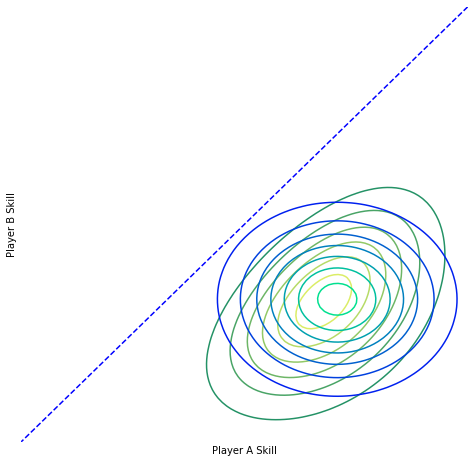

<Figure size 432x288 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params, t)))

# Set up optimizer.
D = 2
init_mean     = np.zeros(D)
init_log_std  = random.normal(key, shape = [D]) # TODO.
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

print("Finali Iteration {} lower bound {}".format(n_iters-1, objective(params, n_iters-1)))

def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and an array of game outcomes, and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
  return log_posterior_beat_each_other_10_times(z1z2[0],z1z2[1]) # TODO

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg,rng, params, num_samples_per_iter)# TODO

**e) [2pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 51%|█████     | 51/100 [00:01<00:00, 56.14it/s]

Iteration 0 lower bound 17.624521255493164
Iteration 25 lower bound 15.784345626831055
Iteration 50 lower bound 15.823675155639648
Iteration 75 lower bound 15.860443115234375


100%|██████████| 100/100 [00:01<00:00, 74.82it/s]


Finali Iteration 99 lower bound 15.642051696777344


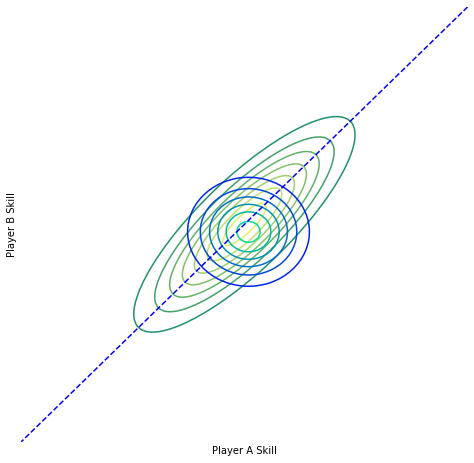

<Figure size 432x288 with 0 Axes>

In [ ]:
@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)
print("Finali Iteration {} lower bound {}".format(n_iters-1, objective(params, n_iters-1)))


def approx_posterior_2d(z1, z2):
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)


1. The true posterior shows that skills of A and B are very close to each other and they are likely at the same level, but the approximation posterior does not show tis.\
2. Yes, because a fully parameterized Gaussian captures more information.

## 1.3 [25pts] Approximate inference conditioned on real data

The dataset from $\texttt{tennis_data.mat}$ contains data on 1801 tennis games amongst 107 players:
 - W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.





In [ ]:
wget.download("https://probmlcourse.github.io/csc412/assignments/assignment_2/tennis_data.mat")
data = scipy.io.loadmat('tennis_data.mat')

games = data['G'] - 1 # A list of pairs of player numbers, representing game outcomes. (shape (1081, 2))
names = data['W']     # A list of names of players, corresponding to the player numbers. (shape (107, 1))

print(games[0,:])
print(names[0])

[0 1]
[array(['Rafael-Nadal'], dtype='<U12')]




**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
  # matches is an array of size (num_games x 2)
  # zs is an array of size (num_players, num_samples)

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_skills = zs[winning_player_ixs] 
  losing_player_skills = zs[losing_player_ixs] 
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills) 
  return np.sum(log_likelihoods)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset. Report the final negative ELBO estimate after optimization.

In [ ]:
# Hyperparameters
num_players = 107
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150
key = PRNGKey(0)

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_joint_probability,rng, params, num_samples_per_iter)# TODO

**c) [1pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = np.zeros(num_players)
init_std  = np.zeros(num_players)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


Optimizing variational parameters...


  5%|▌         | 26/500 [00:02<00:27, 17.48it/s]

Iteration 0 lower bound 1186.4822998046875
Iteration 25 lower bound 1172.8236083984375


 15%|█▌        | 76/500 [00:02<00:06, 61.30it/s]

Iteration 50 lower bound 1146.538330078125
Iteration 75 lower bound 1144.3675537109375


 25%|██▌       | 126/500 [00:02<00:03, 103.82it/s]

Iteration 100 lower bound 1144.565673828125
Iteration 125 lower bound 1144.3046875


 35%|███▌      | 176/500 [00:02<00:02, 124.13it/s]

Iteration 150 lower bound 1144.0537109375
Iteration 175 lower bound 1144.3070068359375


 45%|████▌     | 226/500 [00:03<00:01, 154.61it/s]

Iteration 200 lower bound 1144.236328125
Iteration 225 lower bound 1144.291748046875


 55%|█████▌    | 276/500 [00:03<00:01, 173.29it/s]

Iteration 250 lower bound 1143.934814453125
Iteration 275 lower bound 1144.21728515625


 65%|██████▌   | 326/500 [00:03<00:01, 170.05it/s]

Iteration 300 lower bound 1144.195068359375
Iteration 325 lower bound 1144.046875


 75%|███████▌  | 376/500 [00:04<00:00, 168.85it/s]

Iteration 350 lower bound 1144.3035888671875
Iteration 375 lower bound 1144.3499755859375


 85%|████████▌ | 426/500 [00:04<00:00, 166.08it/s]

Iteration 400 lower bound 1144.8079833984375
Iteration 425 lower bound 1144.3662109375


100%|██████████| 500/500 [00:04<00:00, 108.75it/s]

Iteration 450 lower bound 1143.9383544921875
Iteration 475 lower bound 1144.51611328125


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

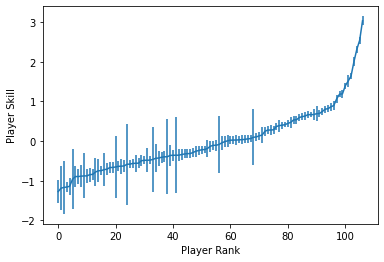

In [ ]:
mean_skills, logstd_skills = get_params(opt_state)# TODO.  Hint: You don't need to do simple Monte Carlo here.
order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(107), mean_skills[order], np.square(np.exp(logstd_skills))[order])

**e) [2pts]** List the names of the 10 players with the highest mean skill under the variational model.


In [ ]:
temp = names[order]
for i in range(1,11):
    print( temp[-i])

[array(['Novak-Djokovic'], dtype='<U14')]
[array(['Roger-Federer'], dtype='<U13')]
[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Andy-Murray'], dtype='<U11')]
[array(['David-Ferrer'], dtype='<U12')]
[array(['Robin-Soderling'], dtype='<U15')]
[array(['Jo-Wilfried-Tsonga'], dtype='<U18')]
[array(['Juan-Martin-Del-Potro'], dtype='<U21')]
[array(['Tomas-Berdych'], dtype='<U13')]
[array(['Richard-Gasquet'], dtype='<U15')]


**f) [1pt]** Plot the joint posterior over the skills of Roger Federer and Rafael Nadal.

[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Roger-Federer'], dtype='<U13')]


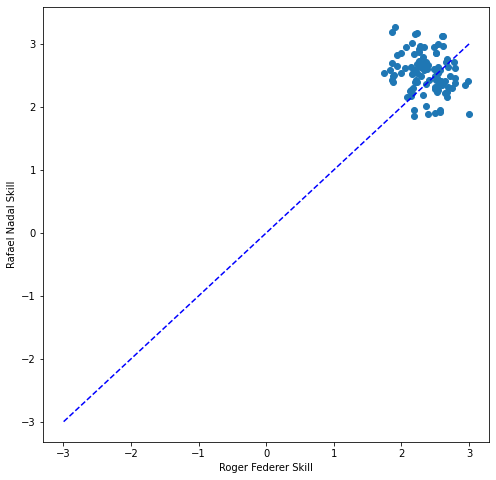

In [ ]:
nadal_ix = 0
federer_ix = 4
print(names[nadal_ix])
print(names[federer_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Roger Federer Skill") 
plt.ylabel("Rafael Nadal Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

rngs = random.split(random.PRNGKey(t), 100)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

# TODO:  Hint:  Use plt.scatter()
plt.scatter( samples[:,nadal_ix] , samples[:,federer_ix]  )

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Let $A = \begin{bmatrix} 1 & -1  \\0 & 1\end{bmatrix} $be the corresponding matrix of the linear transformation such that

$$ A \begin{bmatrix} z_A  \\ z_B\end{bmatrix} = \begin{bmatrix} z_A-z_B  \\ z_B\end{bmatrix}$$
Sinnce $\begin{bmatrix} z_A  \\ z_B\end{bmatrix} \sim \mathcal N (\mu, \Sigma) = \mathcal N (\begin{bmatrix} μ_a  \\ \mu_b \end{bmatrix}, \begin{bmatrix} \sigma_a^2&0  \\ 0& \sigma_b^2 \end{bmatrix})   $

$$A \begin{bmatrix} z_A  \\ z_B\end{bmatrix} \sim \mathcal N (\mu, \Sigma) = \mathcal N (\begin{bmatrix} μ_a-\mu_b  \\ \mu_b \end{bmatrix}, \begin{bmatrix} 1 & -1  \\0 & 1\end{bmatrix} \begin{bmatrix} \sigma_a^2&0  \\ 0& \sigma_b^2 \end{bmatrix} \begin{bmatrix} 1 & 0  \\-1 & 1\end{bmatrix}) $$
$$ = \mathcal N (\begin{bmatrix} μ_a-\mu_b  \\ \mu_b \end{bmatrix}, \begin{bmatrix} \sigma_a^2 + \sigma_b^2 & -\sigma_b^2  \\ -\sigma_b^2 & \sigma_b^2 \end{bmatrix} )$$
$y_a = z_A-z_B$, when $y_a > 0$, skill of player A is better than player B. Since $X_A \sim \mathcal N (μ_a-\mu_b , \sigma_a^2 + \sigma_b^2 )$, 
$$p(y_a > 0) = 1 - \int_{-\infty}^{0} \frac{1}{\sqrt{\sigma_a^2 + \sigma_b^2}\sqrt{2\pi} } \; e^{ -\frac{(y_a-\mu_a+\mu_b)^2}{2(\sigma_a^2 + \sigma_b^2)} } dy_a$$

**h) [2pts]** Compute the probability under your approximate posterior that Roger Federer has higher skill than Rafael Nadal. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `jax.scipy.stats.norm.cdf` for the exact formula.

In [ ]:
# TODO

#approximate posterior
federer_mean= mean_skills[federer_ix]
federer_var = np.square(np.exp(logstd_skills[federer_ix]))
nadal_mean= mean_skills[nadal_ix]
nadal_var = np.square(np.exp(logstd_skills[nadal_ix]))
calculated_prob = 1- jax.scipy.stats.norm.cdf(0, loc= federer_mean-nadal_mean, scale=np.sqrt(federer_var+nadal_var))

#sampling
samples_diff = federer_mean-nadal_mean + np.sqrt(federer_var+nadal_var)*random.normal(random.PRNGKey(t),[10000])
sampled_prob = np.mean(samples_diff>0)

print("probability under approximated posterior: ", calculated_prob)
print("probability under sampling: ", sampled_prob)

probability under approximated posterior:  0.7116787
probability under sampling:  0.7044


In [ ]:
a = np.array([1,0,0,1])
np.mean(a>0)

DeviceArray(0.5, dtype=float32)

**i) [2pts]** Compute the probability that Roger Federer is better than the player with the lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO

#approximate posterior
federer_mean= mean_skills[federer_ix]
federer_var = np.square(np.exp(logstd_skills[federer_ix]))
low_mean= mean_skills[order[0]]
low_var = np.square(np.exp(logstd_skills[order[0]]))
calculated_prob = 1- jax.scipy.stats.norm.cdf(0, loc= federer_mean-low_mean, scale=np.sqrt(federer_var+low_var))

#sampling
samples_diff = federer_mean-low_mean + np.sqrt(federer_var+low_var)*random.normal(random.PRNGKey(t),[10000])
sampled_prob = np.mean(samples_diff>0)

print("probability under approximated posterior: ", calculated_prob)
print("probability under sampling: ", sampled_prob)

probability under approximated posterior:  1.0
probability under sampling:  1.0


**j) [2 pts]** Imagine that we knew ahead of time that we were examining the skills of top tennis players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?



```
# This is formatted as code
```

No, because it means that all players now have better skills but the relative skill levels between players do not change.

**k) [2 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

The methods in HW2 is better. The methods used here is less flexible.

# 2. [50pts] Expectation-Maximization (EM) algorithm

In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2.1 [7pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [ ]:
num_samples = 400 # TODO
cov = np.array([[10,7],[7,10]])# TODO
mean_1 = np.array([0.1,0.1])# TODO
mean_2 = np.array([6.0,0.1])# TODO

x_class1 = np.random.multivariate_normal(mean_1, cov, 200)# TODO
x_class2 = np.random.multivariate_normal(mean_2, cov, 200) # TODO
xy_class1 = np.hstack((x_class1,np.zeros((x_class1.shape[0], 1)))) # TODO
xy_class2 = np.hstack((x_class2,np.ones((x_class1.shape[0], 1))))# TODO

data_full = np.vstack((xy_class1,xy_class2))# TODO complete data
np.random.shuffle(data_full)
data = data_full[:,:2]# TODO incomplete data
labels = data_full[:, 2]# TODO

In [ ]:
print(np.ones((10,1)))
print(np.hstack((np.ones((10,1)),np.array([2]*10).reshape((10,1)))))
print()
print([[2]]*10)
print(np.hstack((np.ones((10,1)),np.full((10,1),2))))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]]

[[2], [2], [2], [2], [2], [2], [2], [2], [2], [2]]
[[1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]]


**b) [2pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

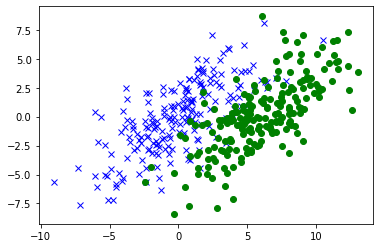

In [ ]:
plt.plot( x_class1[:,0], x_class1[:,1], 'bx' ) # first class, x shape
plt.plot( x_class2[:,0], x_class2[:,1], 'go' )  # second class, circle shape

## 2.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat\mu_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat\mu_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error. 

**a) [2pts]** Complete the `cost` function.

In [ ]:
def cost(data, R, Mu):
    N, D = data.shape# TODO
    K = R.shape[1]# TODO
    # TODO
    Mus_for_each = R @ Mu.T
    J = np.sum(np.square(data-Mus_for_each))
    return J

**b) [4pts]** K-Means assignment step.

In [ ]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape# TODO: Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N,K)) # TODO
    # TODO assign all r[:, k]

    #calculate eucliean distance with two centrals
    for i in range(0,K):
        diff = data-Mu[:,i]
        r[:,i] = np.linalg.norm(diff, axis=1)
    #print(" r ---------------")
    #print(r[:20])
    arg_min = np.argmin(r,axis=1) # TODO: argmax/argmin along dimension 1
    #print(arg_min[:20])
    R_new = np.zeros((N,K)) # TODO: Set to zeros/ones with shape (N, K)
    R_new[range(N), arg_min] = 1 # TODO Assign to 1
    #print(" R_new ---------------")
    #print(R_new[:20])
    return R_new

**c) [2pts]** K-Means refitting step.

In [ ]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # TODO: number of datapoints and dimension of datapoint
    K = R.shape[1] # TODO: number of clusters
    counts = np.sum(R, axis= 0)
    Mu_new = (data.T @ R) / counts[:, None] # TODO
    return Mu_new

In [ ]:
a = np.array([[1,1,1],[2,2,2]])
v = np.array([1,2,3])
print(a/v[:None])

[[1.         0.5        0.33333333]
 [2.         1.         0.66666667]]


**d) [4pts]** Run this cell to call the K-Means algorithm.

In [ ]:
N, D = 400, 2# TODO
K = 2 # TODO
max_iter = 100
class_init = np.random.randint(2, size=N).astype(int)# TODO
R = np.zeros((N,K))
R[range(N),class_init] = 1# TODO
print("inital R")
print(R[:20])
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)

cost_list = []
for it in range(max_iter):
    R = km_assignment_step(data, Mu)# TODO
    Mu = km_refitting_step(data, R, Mu) # TODO
    temp = cost(data, R, Mu)
    cost_list.append(temp)
    print(it, temp)

class_1 = data[np.where(R[:,0]==1)]# TODO
class_2 = data[np.where(R[:,1]==1)]# TODO

inital R
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
0 8957.099993943011
1 5887.158704668756
2 5451.86570819352
3 5368.98178726473
4 5371.290039219283
5 5365.088169315933
6 5371.290039219283
7 5365.088169315933
8 5371.290039219283
9 5365.088169315933
10 5371.290039219283
11 5365.088169315933
12 5371.290039219283
13 5365.088169315933
14 5371.290039219283
15 5365.088169315933
16 5371.290039219283
17 5365.088169315933
18 5371.290039219283
19 5365.088169315933
20 5371.290039219283
21 5365.088169315933
22 5371.290039219283
23 5365.088169315933
24 5371.290039219283
25 5365.088169315933
26 5371.290039219283
27 5365.088169315933
28 5371.290039219283
29 5365.088169315933
30 5371.290039219283
31 5365.088169315933
32 5371.290039219283
33 5365.088169315933
34 5371.290039219283
35 5365.088169315933
36 5371.290039219283
37 5365.088169315933
38 5371.290039219283
39 

In [ ]:
def error_rate(responsibility,labels):
    label_vector = np.zeros((N,K))
    label_vector[range(N),labels.astype(int)] = 1
    diff_true = label_vector-responsibility
    wrong = np.count_nonzero(diff_true[:,0])
    return wrong/400

In [ ]:
print("misclassification rate: ", error_rate(R, labels))

misclassification rate:  0.2475


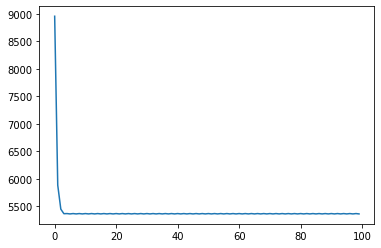

In [ ]:
plt.plot( list(range(max_iter)), cost_list ) 

In [ ]:
print(Mu)

[[-0.44108579  6.39209883]
 [-1.67036202  1.7668363 ]]


In [ ]:
np.random.randint(2, size=10)
x = np.array([[1,0,2,0,3,0,4,5,6,7,8],[3,6,4,1,7,0,1,3,1,0,0]])
print(np.where(x==0))
y =np.random.randint(2, size=10).astype(int)
print(y)
x[:,np.where(y==1)] = 1
print(x)

(array([0, 0, 0, 1, 1, 1]), array([ 1,  3,  5,  5,  9, 10]))
[0 0 0 0 0 0 0 1 1 0]
[[1 0 2 0 3 0 4 1 1 7 8]
 [3 6 4 1 7 0 1 1 1 0 0]]


**e) [2pts]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


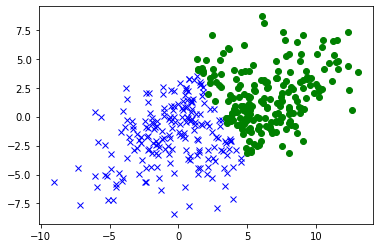

In [ ]:
plt.plot(class_1[:,0], class_1[:,1], 'bx' ) # TODO first class, x shape
plt.plot(class_2[:,0], class_2[:,1], 'go' ) # TODO second class, circle shape

## 2.3 [21pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$ for the covariances.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [ ]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    L, T = 0., 0.
    # TODO: given n, k, compute the likelihood from the k-th Gaussian weighted by the mixing coefficients
    for i in range(N):
        T = 0.
        for j in range(K):
           T +=Pi[j]*normal_density(data[i], Mu[:,j], Sigma[j])
        T = np.log(T)
        L += T

    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [ ]:
from re import L
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # TODO number of mixtures
    Gamma = np.zeros((N,K)) # TODO zeros of shape (N,K), matrix of responsibilities

    # TODO: given n, k, normalize by sum across second dimension (mixtures)
    for i in range(N):
        for j in range(K):
            Gamma[i,j] = Pi[j]*normal_density(data[i],Mu[:, j], Sigma[j])
    Gamma = (Gamma.T/np.sum(Gamma, axis = 1)).T
    return Gamma

In [ ]:

a = np.array([[1,1,1],[2,2,2]])
a = (a.T/np.sum(a, axis = 1)).T
print(np.sum(a, axis = 1))
print(a)

[1. 1.]
[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


**c) [5pts]** Gaussian Mixture Maximization Step.

In [ ]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    N, D = data.shape # TODO Number of datapoints and dimension of datapoint
    K = Gamma.shape[1]  # TODO number of mixtures
    Nk = np.sum(Gamma, axis = 0) # TODO Sum along first axis 
    Mu = (data.T @ Gamma)/Nk # TODO
    Sigma = [0]*K # TODO

    # TODO: fill in Sigma[k] for each k
    for i in range(K):
        Sigma[i] = (((data-Mu[:,i]).T * Gamma[:,i] ) @ (data-Mu[:,i]))/Nk[i]

    Pi = Nk/N # TODO
    return Mu, Sigma, Pi

In [ ]:
a = [0,1]
a[0] = [[1]]
print(a)
a = np.array([[1,1,1],[2,2,2]])
a = a*[1,2,3]
print(a)

[[[1]], 1]
[[1 2 3]
 [2 4 6]]


**d) [4pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [ ]:
N, D = 400, 2# TODO
K = 2 # TODO
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

log_like = []
max_iter  = 200

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi) # TODO
    Mu, Sigma, Pi = gm_m_step(data, Gamma) # TODO
    l = log_likelihood(data, Mu, Sigma, Pi)
    log_like.append(l)
    #print(it, l)


class_1 = data[np.where(Gamma[:,0]>Gamma[:,1])]# TODO
class_2 = data[np.where(Gamma[:,1]>Gamma[:,0])]# TODO

In [ ]:
print(Mu.shape)

(2, 2)


**e) [2pts]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

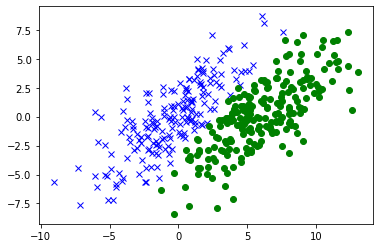

In [ ]:
plt.plot(class_1[:,0], class_1[:,1], 'bx' ) # TODO first class, x shape
plt.plot(class_2[:,0], class_2[:,1], 'go' ) # TODO second class, circle shape

In [ ]:
temp = np.zeros((N,K))
temp[np.where(Gamma[:,0]>Gamma[:,1])]=[1,0]
temp[np.where(Gamma[:,1]>Gamma[:,0])]=[0,1]
print("error rate:", error_rate(temp, labels))

error rate: 0.1075


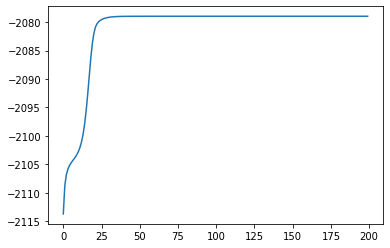

In [ ]:
plt.plot( list(range(200)), log_like ) 

In [ ]:
print(temp)

## 2.4 [8pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]
 


Your answer here.
1. EM is better then k-mean in terms of cluster assignments. (Also see the experiment code below)
2. K-means usually converge within 10 iterations, but EM takes 50-100 rounds to converge, so K-means has better performance in terms of convergence rate.
3. Yes, in different random data set, the performance of two algorithms various.
4. If increasing the number of K, we might see EM is much more slower than k-means but the difference in their performance gets larger

In [ ]:
# your code here, if you have any

def experiments():
    num_samples = 400 # TODO
    cov = np.array([[10,7],[7,10]])# TODO
    mean_1 = np.array([0.1,0.1])# TODO
    mean_2 = np.array([6.0,0.1])# TODO

    x_class1 = np.random.multivariate_normal(mean_1, cov, 200)# TODO
    x_class2 = np.random.multivariate_normal(mean_2, cov, 200) # TODO
    xy_class1 = np.hstack((x_class1,np.zeros((x_class1.shape[0], 1)))) # TODO
    xy_class2 = np.hstack((x_class2,np.ones((x_class1.shape[0], 1))))# TODO

    data_full = np.vstack((xy_class1,xy_class2))# TODO complete data
    np.random.shuffle(data_full)
    data = data_full[:,:2]# TODO incomplete data
    labels = data_full[:, 2]# TODO

    #k-means
    print("running K-means---------------")
    N, D = 400, 2# TODO
    K = 2 # TODO
    max_iter = 100
    class_init = np.random.randint(2, size=N).astype(int)# TODO
    R = np.zeros((N,K))
    R[range(N),class_init] = 1# TODO
    Mu = np.zeros([D, K])
    Mu[:, 1] = 1.
    R.T.dot(data), np.sum(R, axis=0)

    for it in range(max_iter):
        R = km_assignment_step(data, Mu)# TODO
        Mu = km_refitting_step(data, R, Mu) # TODO
        if it%10==0:
            print(it, cost(data, R, Mu))

    k_error = error_rate(R, labels)

    #EM
    print("running EM ---------------")
    N, D = 400, 2# TODO
    K = 2 # TODO
    Mu = np.zeros([D, K])
    Mu[:, 1] = 1.
    Sigma = [np.eye(2), np.eye(2)]
    Pi = np.ones(K) / K
    Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

    log_like = []
    max_iter  = 200

    for it in range(max_iter):
        Gamma = gm_e_step(data, Mu, Sigma, Pi) # TODO
        Mu, Sigma, Pi = gm_m_step(data, Gamma) # TODO
        
        if it%10==0:
            l = log_likelihood(data, Mu, Sigma, Pi)
            log_like.append(l)
            print(it, l)
        
    temp = np.zeros((N,K))
    temp[np.where(Gamma[:,0]>Gamma[:,1])]=[1,0]
    temp[np.where(Gamma[:,1]>Gamma[:,0])]=[0,1]
    em_error = error_rate(temp,labels)

    return k_error, em_error

In [ ]:
# run 5 times and compare errors
k_em_errors = []
for i in range(5):
    errors = experiments()
    k_em_errors.append(errors)
    if errors[0]>errors[1]:
        print("In round {}, k-means is better.".format(i))
    else:
        print("In round {}, EM is better.".format(i))


running K-means---------------
0 7413.216790907767
10 5445.956090222116
20 5445.956090222116
30 5445.956090222116
40 5445.956090222116
50 5445.956090222116
60 5445.956090222116
70 5445.956090222116
80 5445.956090222116
90 5445.956090222116
running EM ---------------
0 -2120.4970588727774
10 -2108.3982595785355
20 -2104.432294120705
30 -2103.8101083636984
40 -2103.7707072639428
50 -2103.7651482001875
60 -2103.7627487048017
70 -2103.7615070035445
80 -2103.7608581204227
90 -2103.7605194279695
100 -2103.7603428724033
110 -2103.760250922502
120 -2103.760203066671
130 -2103.7601781714607
140 -2103.7601652249423
150 -2103.7601584938247
160 -2103.760154994795
170 -2103.7601531761156
180 -2103.7601522309096
190 -2103.760151739699
In round 0, k-means is better.
running K-means---------------
0 11353.825532414936
10 5286.848176541053
20 5286.848176541053
30 5286.848176541053
40 5286.848176541053
50 5286.848176541053
60 5286.848176541053
70 5286.848176541053
80 5286.848176541053
90 5286.8481765410

In [ ]:
for i in range(5):
    if k_em_errors[i][0]<k_em_errors[i][1]:
        print("In round {}, K-means: {}, EM: {}. k-means is better.".format(k_em_errors[i][0],k_em_errors[i][1],i))
    else:
        print("In round {}, K-means: {}, EM: {}. EM is better.".format(k_em_errors[i][0],k_em_errors[i][1],i))


In round 0.22, K-means: 0.135, EM: 0. EM is better.
In round 0.245, K-means: 0.13, EM: 1. EM is better.
In round 0.23, K-means: 0.0625, EM: 2. EM is better.
In round 0.2825, K-means: 0.115, EM: 3. EM is better.
In round 0.255, K-means: 0.155, EM: 4. EM is better.
